In [7]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import seaborn as sns
import matplotlib.pyplot as plt


In [11]:
# Load the datasets
customers = pd.read_csv('Customers.csv')
products = pd.read_csv('Products.csv')
transactions = pd.read_csv('Transactions.csv')
# Convert date columns to datetime format
customers['SignupDate'] = pd.to_datetime(customers['SignupDate'], errors='coerce')
transactions['TransactionDate'] = pd.to_datetime(transactions['TransactionDate'], errors='coerce')
# Merge datasets
merged_data = transactions.merge(customers, on="CustomerID", how="left").merge(products, on="ProductID", how="left")




In [12]:
# Replace infinities with NaN and drop rows with NaN values
merged_data = merged_data.replace([float('inf'), -float('inf')], pd.NA)
merged_data = merged_data.dropna()


In [15]:
 #Feature Engineering ---
# Aggregate transaction data by CustomerID
customer_features = merged_data.groupby("CustomerID").agg(
    avg_purchase_value=("TotalValue", "mean"),
    total_spent=("TotalValue", "sum"),
    num_transactions=("TransactionID", "count"),
    most_frequent_category=("Category", lambda x: x.mode()[0] if not x.mode().empty else "Unknown")
).reset_index()

In [17]:
# Encode categorical features (e.g., most_frequent_category)
# Encode categorical features (e.g., most_frequent_category)
categorical_features = customer_features[["most_frequent_category"]]
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')  # Updated argument
categorical_encoded = encoder.fit_transform(categorical_features)
categorical_df = pd.DataFrame(categorical_encoded, columns=encoder.get_feature_names_out(["most_frequent_category"]))


In [18]:
# Combine numerical and encoded categorical features
numerical_features = customer_features[["avg_purchase_value", "total_spent", "num_transactions"]]
scaler = StandardScaler()
numerical_scaled = scaler.fit_transform(numerical_features)

In [19]:
# Final feature matrix
final_features = np.hstack((numerical_scaled, categorical_df))
final_features_df = pd.DataFrame(final_features, index=customer_features['CustomerID'])


In [20]:
# --- Similarity Calculation ---
# Compute cosine similarity
similarity_matrix = cosine_similarity(final_features_df)
similarity_df = pd.DataFrame(similarity_matrix, index=customer_features['CustomerID'], columns=customer_features['CustomerID'])


In [21]:
# --- Lookalike Recommendations ---
lookalike_results = {}

for customer_id in customer_features['CustomerID'][:20]:  # First 20 customers (C0001-C0020)
    similar_customers = similarity_df[customer_id].sort_values(ascending=False).iloc[1:4]  # Top 3 lookalikes
    lookalike_results[customer_id] = [(similar_customer, score) for similar_customer, score in similar_customers.items()]


In [22]:
# Save results to Lookalike.csv
lookalike_list = []
for cust_id, similar_list in lookalike_results.items():
    lookalike_list.append({
        "CustomerID": cust_id,
        "Lookalikes": similar_list
    })


In [28]:
lookalike_df = pd.DataFrame(lookalike_list)
lookalike_df.to_csv("Lookalike.csv", index=False)


In [24]:
# --- Visualizations (Optional) ---
sns.set(style="whitegrid")

<ipython-input-25-9c6f7abe4a2e>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=merged_data.groupby("Category")["TotalValue"].sum().reset_index(),


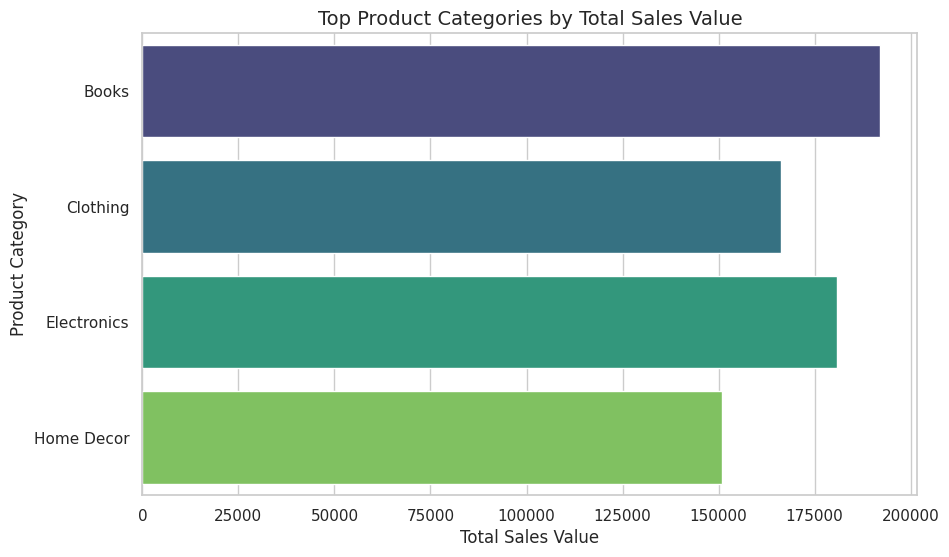

In [25]:
# Top product categories by sales
plt.figure(figsize=(10, 6))
sns.barplot(data=merged_data.groupby("Category")["TotalValue"].sum().reset_index(),
            x="TotalValue", y="Category", palette="viridis")
plt.title("Top Product Categories by Total Sales Value", fontsize=14)
plt.xlabel("Total Sales Value")
plt.ylabel("Product Category")
plt.show()

In [26]:
# Sales trends over time
merged_data['MonthYear'] = merged_data['TransactionDate'].dt.to_period('M')
monthly_sales = merged_data.groupby("MonthYear")["TotalValue"].sum().reset_index()
monthly_sales['MonthYear'] = monthly_sales['MonthYear'].astype(str)


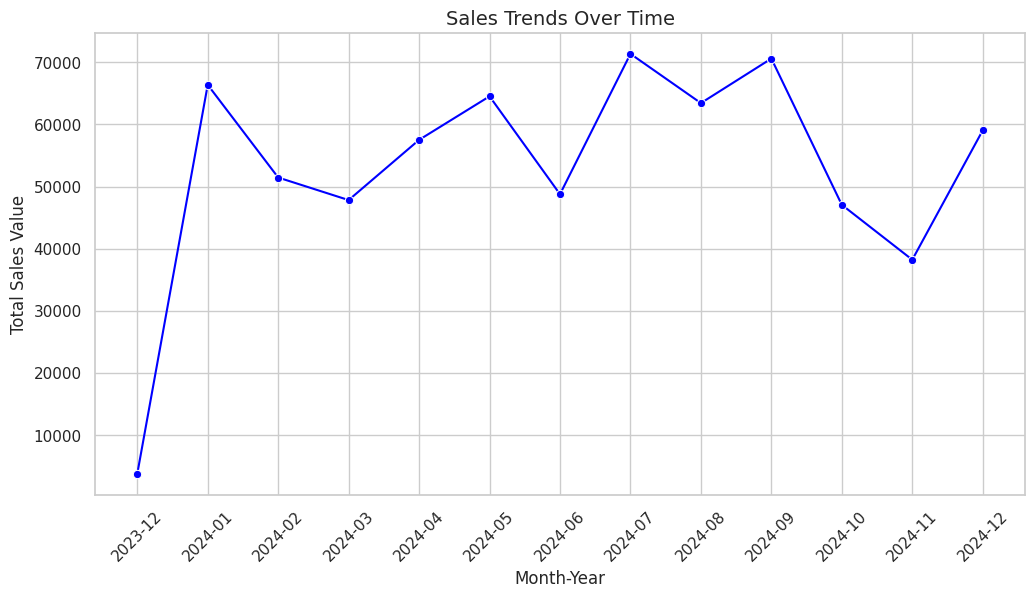

In [27]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=monthly_sales, x="MonthYear", y="TotalValue", marker="o", color="blue")
plt.title("Sales Trends Over Time", fontsize=14)
plt.xlabel("Month-Year")
plt.ylabel("Total Sales Value")
plt.xticks(rotation=45)
plt.show()

In [31]:
lookalike_df.to_csv('Looklike.csv',index=False)
from google.colab import files
files.download('Lookalike.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>